## Install Modules

In [1]:
pip install cmake


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install dlib-19.24.99-cp312-cp312-win_amd64.whl


Processing c:\users\ksaid\onedrive\desktop\realtime driver drowsiness detection - opencv\realtime driver drowsiness detection - opencv\dlib-19.24.99-cp312-cp312-win_amd64.whlNote: you may need to restart the kernel to use updated packages.

dlib is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [3]:
pip install face_recognition


Note: you may need to restart the kernel to use updated packages.


## Import Modules

In [4]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import face_recognition
from scipy.spatial import distance

import warnings
warnings.filterwarnings('ignore')

## Highlight Facial Points in the Image

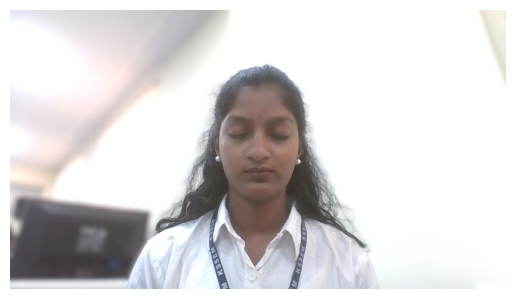

In [ ]:
image_path = "C:\\Users\\ACER\\Downloads\\Realtime Driver Drowsiness Detection - OpenCV (3)\\Realtime Driver Drowsiness Detection - OpenCV\\Realtime Driver Drowsiness Detection - OpenCV\\image.jpg"
image = Image.open(image_path)
plt.axis('off')
plt.imshow(image)
plt.show()

In [7]:
def highlight_facial_points(image_path):
    # load the image
    image_bgr = cv2.imread(image_path)
    # convert from bgr to rgb
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # detect faces in the image
    face_locations = face_recognition.face_locations(image_rgb, model='cnn')

    for face_location in face_locations:
        # get facial landmarks
        landmarks = face_recognition.face_landmarks(image_rgb, [face_location])[0]

        # Iterate over the facial landmarks and draw them on the image
        for landmark_type, landmark_points in landmarks.items():
            for (x, y) in landmark_points:
                cv2.circle(image_rgb, (x, y), 3, (0, 255, 0), -1)

    # plot the image
    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

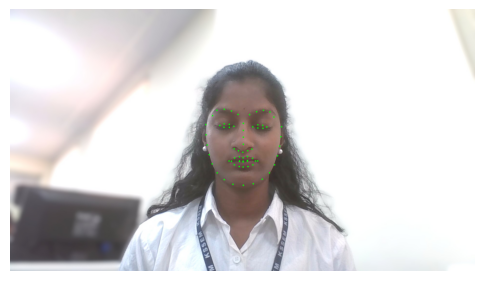

In [8]:
highlight_facial_points(image_path)

<img src='facial_landmarks.png'>

In [9]:
# calculate eye aspect ratio
def eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A+B) / (2.0 * C)
    return ear

# calculate mount aspect ratio
def mouth_aspect_ratio(mouth):
    A = distance.euclidean(mouth[2], mouth[10])
    B = distance.euclidean(mouth[4], mouth[8])
    C = distance.euclidean(mouth[0], mouth[6])
    mar = (A+B) / (2.0 * C)
    return mar

In [10]:
def process_image(frame):
    # define thresholds
    EYE_AR_THRESH = 0.25
    MOUTH_AR_THRESH = 0.6

    if frame is None:
        raise ValueError('Image is not found or unable to open')

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # find all face locations
    face_locations = face_recognition.face_locations(rgb_frame)

    # initiate flags
    eye_flag = mouth_flag = False

    for face_location in face_locations:
        # extract facial landmarks
        landmarks = face_recognition.face_landmarks(rgb_frame, [face_location])[0]
        # extract eye and mouth coordinates
        left_eye = np.array(landmarks['left_eye'])
        right_eye = np.array(landmarks['right_eye'])
        mouth = np.array(landmarks['bottom_lip'])

        # calculate ear and mar
        left_ear = eye_aspect_ratio(left_eye)
        right_ear = eye_aspect_ratio(right_eye)
        ear = (left_ear+right_ear) / 2.0
        mar = mouth_aspect_ratio(mouth)

        # check if eyes are closed
        if ear < EYE_AR_THRESH:
            eye_flag = True

        # check if yawning
        if mar > MOUTH_AR_THRESH:
            mouth_flag = True

    return eye_flag, mouth_flag

In [11]:
img = cv2.imread(image_path)
process_image(img)

(True, False)

## Real Time Drowsiness Detection

In [12]:
import cv2
import winsound
import threading
import time

video_cap = cv2.VideoCapture(0)
count = score = 0
n = 2  # Reduced to process frames faster

# Function to continuously grab frames in a separate thread
def grab_frames(cap):
    global latest_frame, frame_available
    while cap.isOpened():
        success, frame = cap.read()
        if success:
            latest_frame = frame
            frame_available = True
        time.sleep(0.01)  # Small delay to reduce CPU usage

latest_frame = None
frame_available = False
frame_thread = threading.Thread(target=grab_frames, args=(video_cap,), daemon=True)
frame_thread.start()

try:
    while True:
        if not frame_available:
            continue  # Skip iteration if no frame is available

        image = latest_frame.copy()
        image = cv2.resize(image, (640, 400))  # Resize to reduce processing time

        count += 1
        if count % n == 0:
            eye_flag, mouth_flag = process_image(image)  # Ensure this function is fast
            if eye_flag:
                score += 1
            else:
                score = max(0, score - 1)  # Prevent negative score

        # Display score on screen
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image, f"Score: {score}", (10, image.shape[0] - 10), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

        if score >= 8:
            cv2.putText(image, "Drowsy", (image.shape[1] - 130, 40), font, 1, (0, 0, 255), 2, cv2.LINE_AA)
            winsound.Beep(1000, 500)  # Beep alert

        cv2.imshow('drowsiness detection', image)

        if cv2.waitKey(1) & 0xFF != 255:
            break
except KeyboardInterrupt:
    print("Interrupted by user")
finally:
    video_cap.release()
    cv2.destroyAllWindows()
